definition batch normalization layer

- [TensorFlow](https://www.tensorflow.org/api_docs)
- Layer 구성 참고: [TensorFlow's 사용자 정의 층](https://www.tensorflow.org/tutorials/customization/custom_layers?hl=ko), [TensorFlow's 하위 클래스화를 통한 새로운 레이어 및 모델 만들기](https://www.tensorflow.org/guide/keras/custom_layers_and_models?hl=ko)
- 구성 함수 참고: [TensorFlow numpy.append](https://www.tensorflow.org/api_docs/python/tf/experimental/numpy/append), [W3cubDocs](https://docs.w3cub.com/tensorflow~python/tf/keras/backend/std)
- [뉴런층의 출력 확인하기](https://codetorial.net/tensorflow/get_output_of_neuron_layers.html)

<br />

- 현재는 batch에 정규화만 진행했기 때문에, test할 때 이전 값들을 이용하는 것 없음.
- channel에 대한 정규화 값을 확인하지 않았음. (그래서 연산 안 될 수도)

In [1]:
# data for check
import numpy as np
from tensorflow.keras.datasets.mnist import load_data

# model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Layer, Conv2D, Flatten, Dense
from tensorflow.keras.backend import mean, std
from tensorflow.keras.callbacks import EarlyStopping

# visualization
import matplotlib.pyplot as plt

### load data

In [2]:
(train, trainl), (test, testl) = load_data()

In [3]:
train = (train.astype("float32") / 255.0).reshape((len(train), len(test[0]), len(test[1]), -1))
test = (test.astype("float32") / 255.0).reshape((len(test), len(test[0]), len(test[1]), -1))

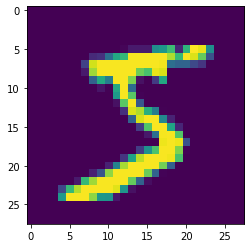

In [4]:
plt.imshow(train[0])

### make custom layer

In [5]:
tf.config.run_functions_eagerly(True)
checks = []
class batch_normalization(Layer):
    def __init__(self, num_outputs):
        super(batch_normalization, self).__init__()
        self.num_outputs = num_outputs

    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]), self.num_outputs])

    def call(self, inputs):
        d_mean = mean(inputs)
        d_std = std(inputs)
        checks.append((d_mean, d_std))

        hiddens = (inputs - d_mean) / d_std
        return tf.matmul(hiddens, self.kernel)

### build model

#### w/o

In [6]:
np.random.seed(3)
tf.random.set_seed(3)

In [7]:
wo_early = EarlyStopping(monitor="val_loss", patience=5)

In [8]:
wo_model = Sequential()
wo_model.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"))
wo_model.add(Conv2D(16, kernel_size=3, activation="relu"))
wo_model.add(Flatten())
wo_model.add(Dense(10, activation="softmax"))

In [9]:
wo_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [10]:
wo_history = wo_model.fit(train, trainl, validation_split=0.3, batch_size=100, epochs=30, callbacks=[wo_early])

X:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
420/420 [==============================] - 10s 15ms/step - loss: 0.2659 - accuracy: 0.9242 - val_loss: 0.1065 - val_accuracy: 0.9693
Epoch 2/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0804 - accuracy: 0.9767 - val_loss: 0.0763 - val_accuracy: 0.9776
Epoch 3/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0572 - accuracy: 0.9824 - val_loss: 0.0768 - val_accuracy: 0.9775
Epoch 4/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0692 - val_accuracy: 0.9788
Epoch 5/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0340 - accuracy: 0.9897 - val_loss: 0.0691 - val_accuracy: 0.9812
Epoch 6/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0254 - accuracy: 0.9921 - val_loss: 0.0726 - val_accuracy: 0.9805
Epoch 7/30
420/420 [==============================] - 6s 15ms/step - loss: 0.0223 - accuracy: 0.9930 - val_loss: 0.0696 - val_accuracy: 0.981

#### with custom

In [11]:
np.random.seed(3)
tf.random.set_seed(3)

In [12]:
early = EarlyStopping(monitor="val_loss", patience=5)

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, input_shape=(28, 28, 1), activation="relu"))
model.add(batch_normalization(32))
model.add(Conv2D(16, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (batch_n (None, 26, 26, 32)        1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                92170     
Total params: 98,138
Trainable params: 98,138
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [16]:
history = model.fit(train, trainl, validation_split=0.3, batch_size=100, epochs=30, callbacks=[early])

Epoch 1/30
420/420 [==============================] - 8s 19ms/step - loss: 0.1908 - accuracy: 0.9448 - val_loss: 0.0886 - val_accuracy: 0.9735
Epoch 2/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0630 - accuracy: 0.9811 - val_loss: 0.0749 - val_accuracy: 0.9775
Epoch 3/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0401 - accuracy: 0.9870 - val_loss: 0.0809 - val_accuracy: 0.9762
Epoch 4/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0309 - accuracy: 0.9894 - val_loss: 0.0875 - val_accuracy: 0.9768
Epoch 5/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0212 - accuracy: 0.9924 - val_loss: 0.0940 - val_accuracy: 0.9786
Epoch 6/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0947 - val_accuracy: 0.9782
Epoch 7/30
420/420 [==============================] - 8s 19ms/step - loss: 0.0140 - accuracy: 0.9948 - val_loss: 0.1063 - val_accuracy: 0.9781

### result

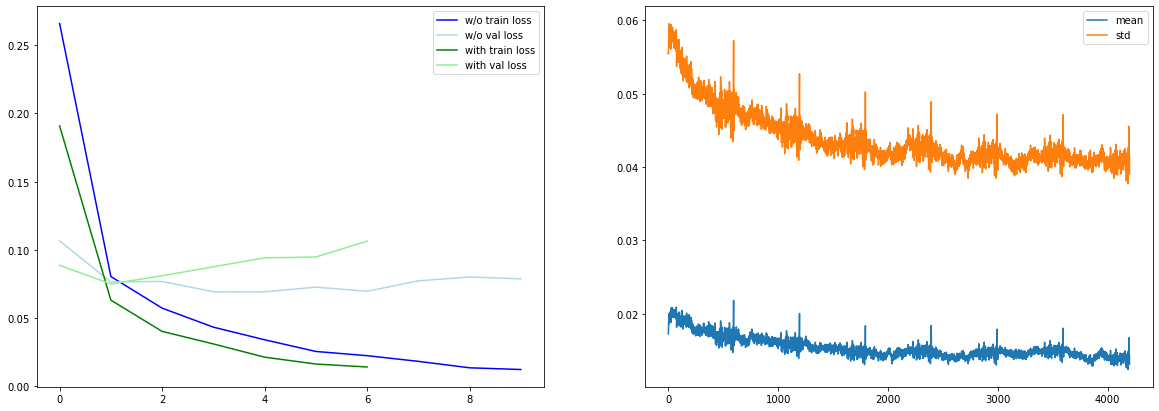

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(wo_history.epoch, wo_history.history["loss"], c="blue", label="w/o train loss")
ax[0].plot(wo_history.epoch, wo_history.history["val_loss"], c="lightblue", label="w/o val loss")

ax[0].plot(history.epoch, history.history["loss"], c="green", label="with train loss")
ax[0].plot(history.epoch, history.history["val_loss"], c="lightgreen", label="with val loss")

ax[1].plot([c[0].numpy() for c in checks[1:]], label="mean")
ax[1].plot([c[1].numpy() for c in checks[1:]], label="std")

for i in range(2):
    ax[i].legend(loc="best")
plt.show()

In [18]:
print("w/o Accuracy:\t%.4f" % wo_model.evaluate(test, testl)[1],
      "with Accuracy:\t%.4f" % model.evaluate(test, testl)[1], sep="\n")

313/313 [==============================] - 2s 7ms/step - loss: 0.0776 - accuracy: 0.9807
w/o Accuracy:	0.9853
with Accuracy:	0.9807


<!-- <img src="before_output.png" /> -->

|  | without | with (custom)
:-:|:-:|:-:|
걸린 시간 | 1분 7.3초 (10 epoch) | 55.9초 (7 epoch) | <!-- 3분 4.9초 | 3분 50.1초 -->
초기 loss / val loss | 0.2659 / 0.1064 | 0.1908 / 0.0906
test accuracy | 0.9853 | 0.9807 | <!-- 0.9866 | 0.9811 -->

- 더 빠르게 수렴, 더 나은 loss 값으로 수렴한다는 측면에서 (제대로 만든 건지는 모르겠지만) batch normalization이 효과가 있어 보임.
- best 모델을 기준으로 하면 custom layer를 가진 모델이 train loss, validation loss 모두 작아서 test accuracy가 더 나아질 가능성이 있어 보임.
<!-- - 사실 지금 batch size 작아보임. -->